<a href="https://colab.research.google.com/github/harmonydata/h_score/blob/main/experiment_with_different_h_score_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing on instrument level - finding the best formula

Experimenting with metrics for an "H-score"

This would be a score that compares instrument similarity, e.g. the GAD-7 is x% similar overall to the PHQ-9


We don't know which is the best recipe for getting an instrument vs instrument similarity, so I am experimenting with a number of different metrics, from simply averaging the item level cosine score, to getting a cosine score for the whole instrument, to generating a crosswalk table and calculating the cosine score as a precision and recall in the crosswalk table.

In [ ]:
!pip install harmonydata

In [ ]:
!pip install kaleido

In [29]:
import harmony
from IPython.display import display, HTML
import numpy as np
from harmony import create_instrument_from_list
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error

In [4]:
harmony.__version__

'1.0.1'

## Make a set of instruments for experimentation

We will take the GAD-7 and also versions of the GAD-7 with more or fewer items

In [5]:
instruments = [harmony.example_instruments["CES_D English"],
               harmony.example_instruments["GAD-7 Portuguese"],
                harmony.example_instruments["GAD-7 English"]]

In [6]:
gad_8 = create_instrument_from_list([q.question_text for q in instruments[2].questions[:8]],
                  instrument_name="GAD-8 English")
instruments.append(gad_8)

In [7]:
instruments[2].questions = instruments[2].questions[:7]

In [8]:

gad_6 = create_instrument_from_list([q.question_text for q in instruments[2].questions[:6]],
                  instrument_name="GAD-6 English")
instruments.append(gad_6)

gad_5 = create_instrument_from_list([q.question_text for q in instruments[2].questions[:5]],
                  instrument_name="GAD-5 English")
instruments.append(gad_5)

In [9]:
reversed_gad_7_questions = [q.question_text for q in instruments[2].questions[:7]]
reversed_gad_7_questions.reverse()

gad_7_reversed = create_instrument_from_list(reversed_gad_7_questions,
                  instrument_name="GAD-7 English reversed")
instruments.append(gad_7_reversed)

In [10]:
html = "<h2>All the instruments</h2>"
for instrument in instruments:
    html += f"<h3>{instrument.instrument_name}</h3>"
    html += "<ol>"
    for question in instrument.questions:
        html += f"<li>{question.question_text}</li>"
    html += "</ol>"

display(HTML(html))

Define what we would expect Harmony to output as the similarity between these items. This is somewhat subjective

In [11]:
desired_outputs = {
    "CES_D English vs CES_D English": 1,
    "CES_D English vs GAD-7 Portuguese": 0.5,
    "CES_D English vs GAD-7 English": 0.5,
    "CES_D English vs GAD-8 English": 0.5,
    "CES_D English vs GAD-6 English": 0.5,
    "CES_D English vs GAD-5 English": 0.5,
    "CES_D English vs GAD-7 English reversed": 0.5,
    "GAD-7 Portuguese vs GAD-7 Portuguese": 1,
    "GAD-7 Portuguese vs GAD-7 English": 1,
    "GAD-7 Portuguese vs GAD-8 English": 7/8,
    "GAD-7 Portuguese vs GAD-6 English": 6/7,
    "GAD-7 Portuguese vs GAD-5 English": 5/7,
    "GAD-7 Portuguese vs GAD-7 English reversed": 1,
    "GAD-7 English vs GAD-7 English": 1,
    "GAD-7 English vs GAD-8 English": 7/8,
    "GAD-7 English vs GAD-6 English": 6/7,
    "GAD-7 English vs GAD-5 English": 5/7,
    "GAD-7 English vs GAD-7 English reversed": 1,
    "GAD-8 English vs GAD-8 English": 1,
    "GAD-8 English vs GAD-6 English": 0.75,
    "GAD-8 English vs GAD-5 English": 0.625,
    "GAD-8 English vs GAD-7 English reversed": 7/8,
    "GAD-6 English vs GAD-6 English": 1,
    "GAD-6 English vs GAD-5 English": 5/6,
    "GAD-6 English vs GAD-7 English reversed": 6/7,
    "GAD-5 English vs GAD-5 English": 1,
    "GAD-5 English vs GAD-7 English reversed": 5/7,
    "GAD-7 English reversed vs GAD-7 English reversed": 1
}

In [12]:
questions, similarity, query_similarity, new_vectors_dict = harmony.match_instruments(instruments)

One variant: smush all questions in each instrument together

In [13]:
instruments_concatenated = []
for instrument in instruments:
    instrument_with_all_questions_in_one_string = create_instrument_from_list([" ".join([question.question_text for question in instrument.questions])],
                  instrument_name=instrument.instrument_name + " all questions concatenated")
    instruments_concatenated.append(instrument_with_all_questions_in_one_string)


In [14]:
instrument_level_questions, instrument_level_similarity, instrument_level_query_similarity, instrument_level_new_vectors_dict = harmony.match_instruments(instruments_concatenated)

In [15]:
len(instrument_level_questions)

7

In [16]:
instrument_level_similarity.shape

(7, 7)

In [17]:
instrument_level_questions[0]

Question(question_no='1', question_intro=None, question_text='I was bothered by things that usually don’t bother me. I did not feel like eating; my appetite was poor. I felt that I could not shake off the blues even with help from my family or friends. I felt I was just as good as other people. I had trouble keeping my mind on what I was doing. I felt depressed. I felt that everything I did was an effort. I felt hopeful about the future. I thought my life had been a failure. I felt fearful. My sleep was restless. I was happy. I talked less than usual. I felt lonely. People were unfriendly. I enjoyed life. I had crying spells. I felt sad. I felt that people dislike me. I could not get “going.”', options=[], source_page=0, instrument_id=None, instrument_name=None, topics_auto=[], topics_strengths=None, nearest_match_from_mhc_auto=None, closest_catalogue_question_match=None, seen_in_catalogue_instruments=None)

In [18]:
instrument_start_pos =[]
instrument_end_pos =[]
cur_start = 0
for instr_idx in range(len(instruments)):
    instrument_start_pos.append(cur_start)
    instrument_end_pos.append(cur_start + len(instruments[instr_idx].questions))
    cur_start += len(instruments[instr_idx].questions)

In [19]:
instrument_start_pos, instrument_end_pos

([0, 20, 27, 34, 42, 48, 53], [20, 27, 34, 42, 48, 53, 60])

Define some candidate functions that we could use for similarity between instruments

In [20]:
def mean_of_cosine_score(item_to_item_similarity_matrix, instrument_1_idx, instrument_2_idx):
    abs_similarities_between_instruments = np.abs(item_to_item_similarity_matrix)

    return np.mean(abs_similarities_between_instruments)

In [21]:
def score_of_whole_instrument_combined(item_to_item_similarity_matrix, instrument_1_idx, instrument_2_idx):
    return np.abs(instrument_level_similarity[instrument_1_idx, instrument_2_idx])

In [49]:
import operator
def get_prec_recall(item_to_item_similarity_matrix):
    abs_similarities_between_instruments = np.abs(item_to_item_similarity_matrix)

    coord_to_sim = {}
    for y in range(abs_similarities_between_instruments.shape[0]):
        for x in range(abs_similarities_between_instruments.shape[1]):
            coord_to_sim[(y,x)] = abs_similarities_between_instruments[y,x]

    best_matches = set()
    is_used_x = set()
    is_used_y = set()
    for (y,x), sim in sorted(coord_to_sim.items(), key=operator.itemgetter(1), reverse=True):
        if x not in is_used_x and y not in is_used_y and abs_similarities_between_instruments[(y,x)] >= 0:
            best_matches.add((x,y))

            is_used_x.add(x)
            is_used_y.add(y)

    precision = len(is_used_x)  / abs_similarities_between_instruments.shape[1]
    recall = len(is_used_y)  / abs_similarities_between_instruments.shape[0]
    return precision, recall

def f1_score_item_level(item_to_item_similarity_matrix, instrument_1_idx, instrument_2_idx):
    precision, recall = get_prec_recall(item_to_item_similarity_matrix)

    f1 = np.mean((precision, recall))

    return f1

def precision_score_item_level(item_to_item_similarity_matrix, instrument_1_idx, instrument_2_idx):
    precision, recall = get_prec_recall(item_to_item_similarity_matrix)

    return precision

def recall_score_item_level(item_to_item_similarity_matrix, instrument_1_idx, instrument_2_idx):
    precision, recall = get_prec_recall(item_to_item_similarity_matrix)

    return recall

In [50]:
calculated_similarities = []

for i in range(len(instruments)):
    instrument_1 = instruments[i]
    for j in range(i, len(instruments)):
        instrument_2 = instruments[j]
        item_to_item_similarity_matrix = similarity[instrument_start_pos[i]:instrument_end_pos[i], instrument_start_pos[j]:instrument_end_pos[j]]

        for instrument_level_similarity_function in [mean_of_cosine_score, score_of_whole_instrument_combined, f1_score_item_level, precision_score_item_level, recall_score_item_level]:

            similarity_score_scalar = instrument_level_similarity_function(item_to_item_similarity_matrix, i, j)

            calculated_similarities.append(
                (instrument_level_similarity_function.__name__, instrument_1.instrument_name, instrument_2.instrument_name, similarity_score_scalar)
            )

In [51]:
df_calculated_similarities = pd.DataFrame()
df_calculated_similarities["function"] = [x[0] for x in calculated_similarities]
df_calculated_similarities["instrument 1"] = [x[1] for x in calculated_similarities]
df_calculated_similarities["instrument 2"] = [x[2] for x in calculated_similarities]
df_calculated_similarities["similarity score"] = [x[3] for x in calculated_similarities]

In [52]:
df_calculated_similarities["instrument pair"] = df_calculated_similarities["instrument 1"] + " vs " + df_calculated_similarities["instrument 2"]

In [53]:
df_calculated_similarities["ground truth"] = df_calculated_similarities["instrument pair"].map(desired_outputs)

In [54]:
df_calculated_similarities

,function,instrument 1,instrument 2,similarity score,instrument pair,ground truth
0,mean_of_cosine_score,CES_D English,CES_D English,0.404563,CES_D English vs CES_D English,1.0
1,score_of_whole_instrument_combined,CES_D English,CES_D English,1.000000,CES_D English vs CES_D English,1.0
2,f1_score_item_level,CES_D English,CES_D English,1.000000,CES_D English vs CES_D English,1.0
3,precision_score_item_level,CES_D English,CES_D English,1.000000,CES_D English vs CES_D English,1.0
4,recall_score_item_level,CES_D English,CES_D English,1.000000,CES_D English vs CES_D English,1.0
...,...,...,...,...,...,...
135,mean_of_cosine_score,GAD-7 English reversed,GAD-7 English reversed,0.568814,GAD-7 English reversed vs GAD-7 English reversed,1.0
136,score_of_whole_instrument_combined,GAD-7 English reversed,GAD-7 English reversed,1.000000,GAD-7 English reversed vs GAD-7 English reversed,1.0
137,f1_score_item_level,GAD-7 English reversed,GAD-7 English reversed,1.000000,GAD-7 English reversed vs GAD-7 English reversed,1.0
138,precision_score_item_level,GAD-7 English reversed,GAD-7 English reversed,1.000000,GAD-7 English reversed vs GAD-7 English reversed,1.0


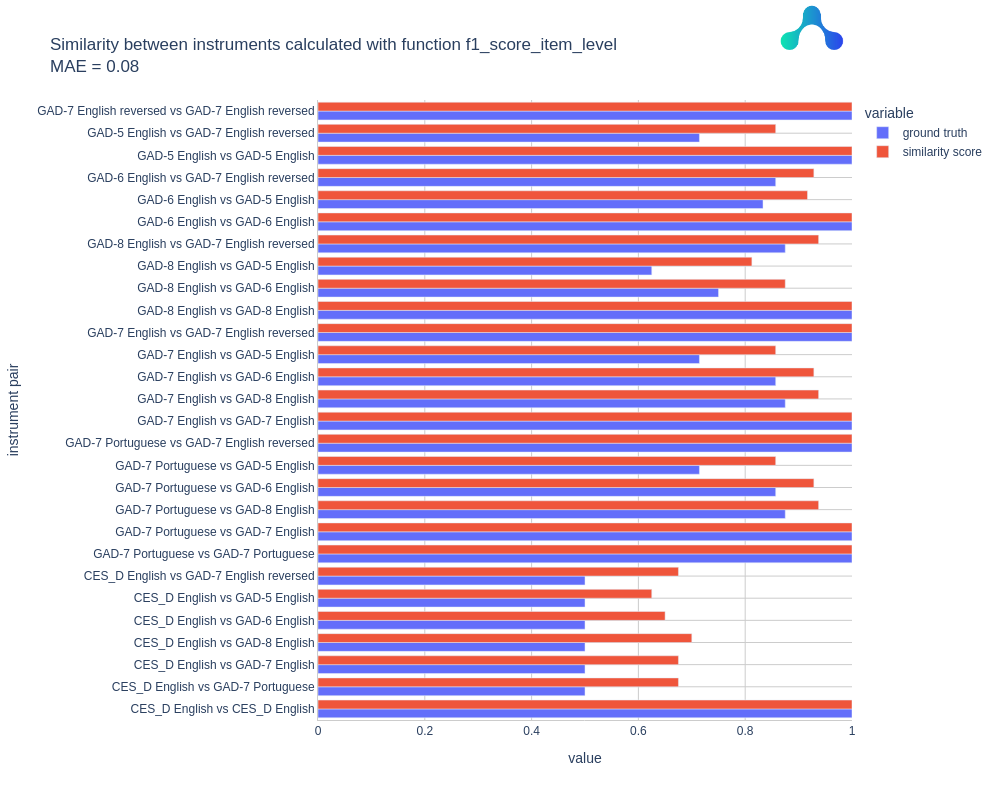

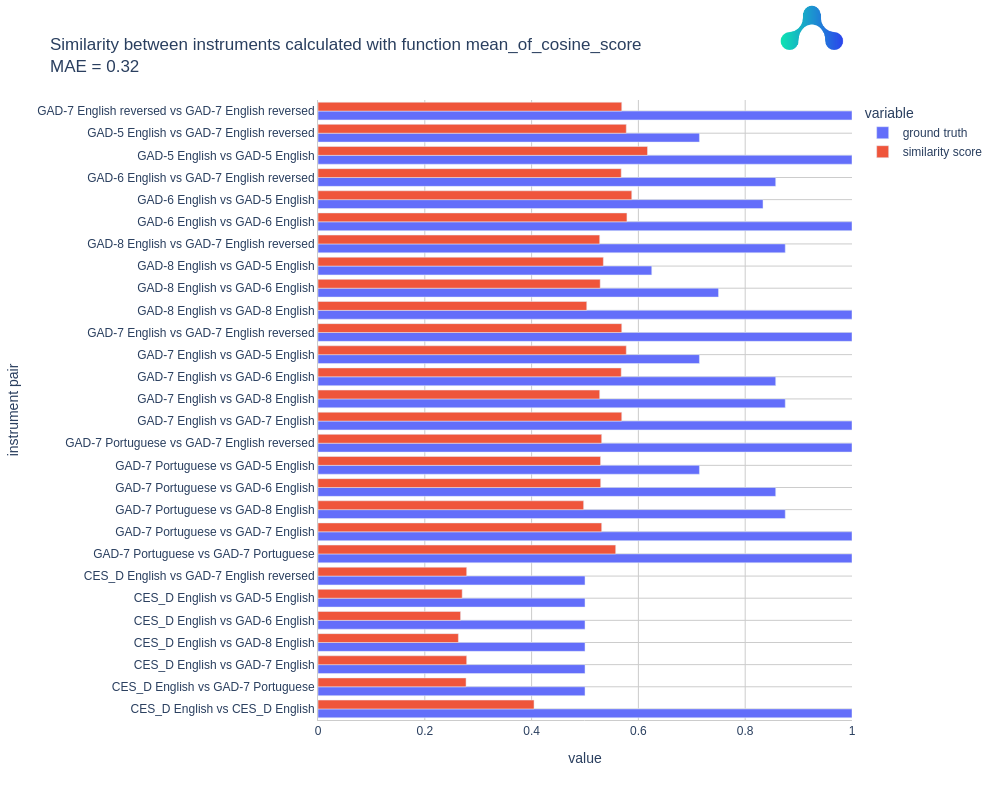

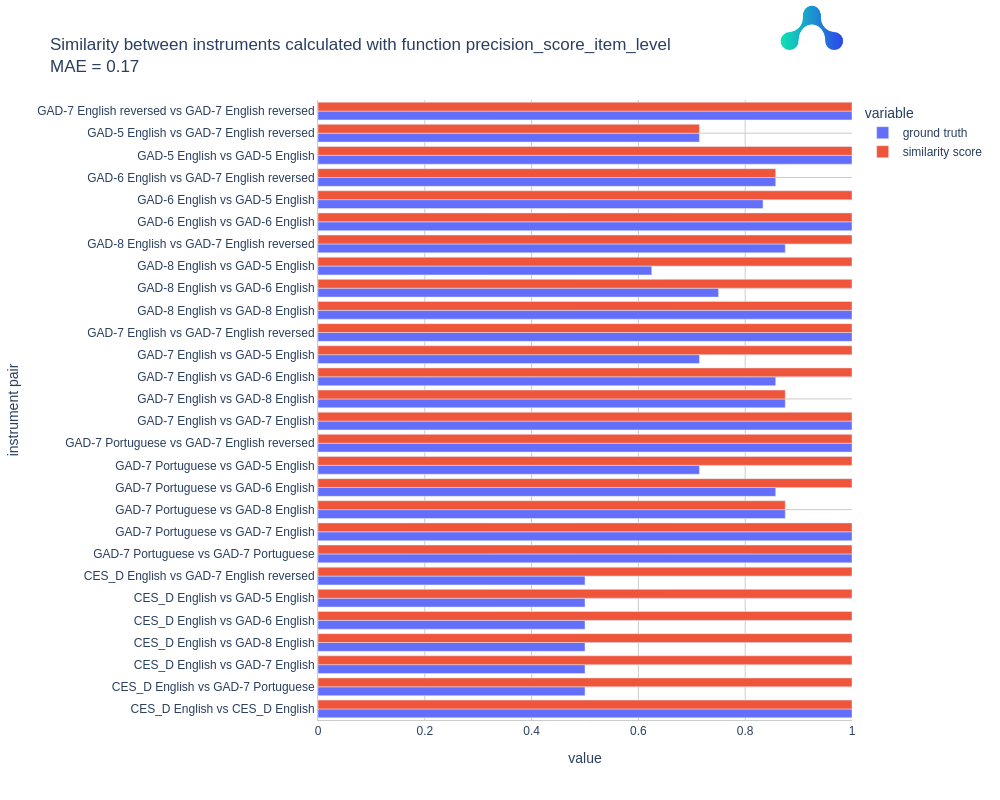

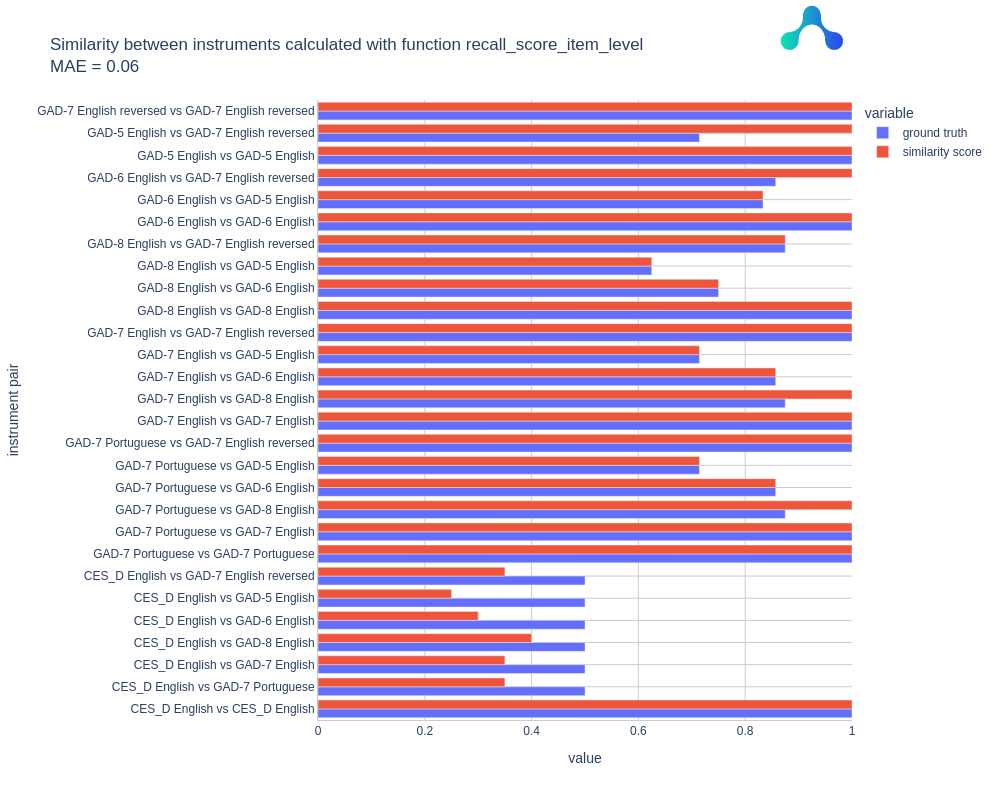

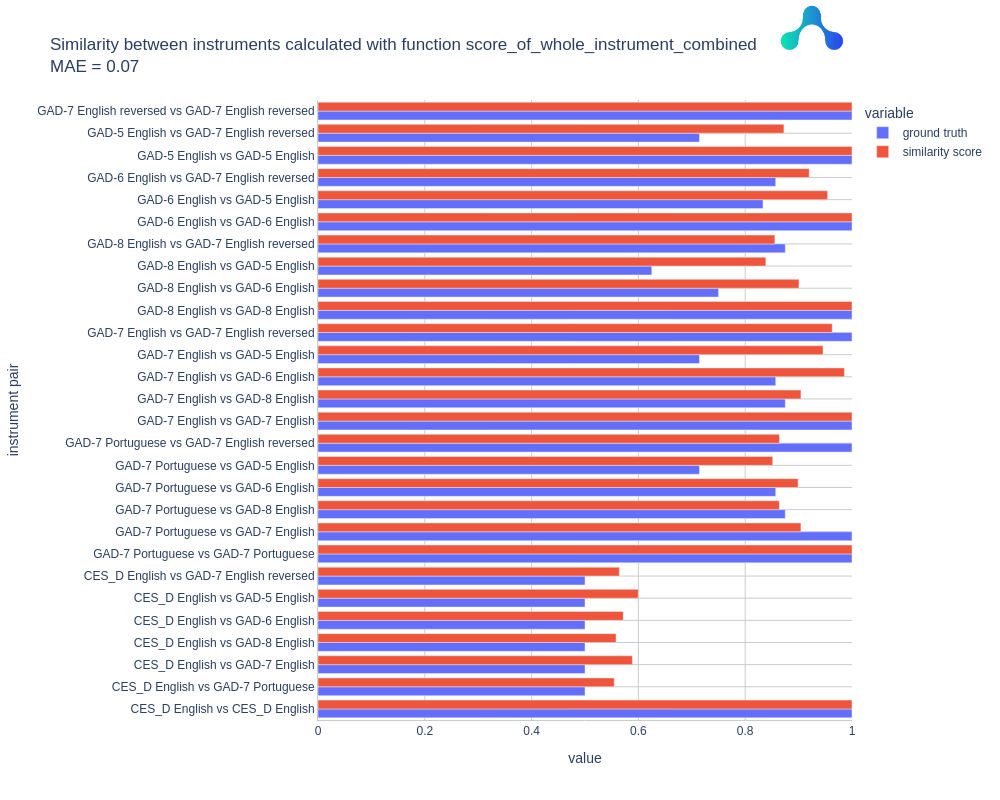

In [78]:
for similarity_function_name, subset in df_calculated_similarities.groupby("function"):

  mae = mean_absolute_error(subset["ground truth"], subset["similarity score"])

  fig = px.bar(data_frame=subset, y="instrument pair", barmode="group", x=["ground truth", "similarity score"], title=f"Similarity between instruments calculated with function {similarity_function_name}<br>MAE = {mae:.2f}")

  fig.update_yaxes(automargin=True)

  fig.add_layout_image(
        dict(
            source="https://raw.githubusercontent.com/harmonydata/brand/main/logomark/PNG/Logomark-04.png",
            xref="paper", yref="paper",
            x=1.05, y=1.05,
            sizex=0.25, sizey=0.25,
            xanchor="right", yanchor="bottom"
        )
    )

  fig.update_xaxes(showline=True, linewidth=1, linecolor='#cccccc', gridcolor='#cccccc')
  fig.update_yaxes(showline=True, linewidth=1, linecolor='#cccccc', gridcolor='#cccccc')

  fig.update_layout(
      width=1000,
      height=800,
      xaxis={'range': [0, 1]},
      paper_bgcolor='rgb(255,255,255)',
      plot_bgcolor='rgb(255,255,255)',
  )

  fig.show(renderer="png")